### Section 3: Machine Learning

---

#### Objectives
Apply unsupervised machine learning techniques to discover hidden patterns in customer behavior and generate actionable business insights.

---

In [1]:
import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [2]:


class kClusterProcessor:
     
    def __init__(self, datapath: str) -> None:
        """
        Initialize the processor with lazy Polars DataFrame.
        """
        self.datapath = datapath
        try:
            self.lazyDf = pl.scan_parquet(datapath)
        except Exception as e:
            print(f"Error initializing the data: {e}")
            raise
        self.df = None
        self.X_scaled = None
        self.kmeans = None


    def extractKMeansFeatures(self) -> pd.DataFrame:
        transactions = (
            self.lazyDf
            .group_by('user_id')
            .agg([
                pl.col('price').sum().alias('TotalRevenue'),
                (pl.col("event_type") == "purchase").sum().alias("purchaseFrequency"),
                (pl.col("event_type") == "view").sum().alias("viewFrequency"),
                pl.col('sessionDuration').mean().alias("EngagementLevel"),
                pl.col('category_id').n_unique().alias("CategoryDiversity")
            ])
            .with_columns(
                (pl.when(pl.col("viewFrequency") > 0)
                .then(pl.col("purchaseFrequency") / pl.col("viewFrequency"))
                .otherwise(0))
                .alias("ConversionRate")
            )
        )
        df = transactions.collect().to_pandas()
        self.df = df
        return df


    def logTransformFeatures(self, cols=None):
        """
        Apply log1p transformation to reduce skew in numeric features.

        Parameters
        ----------
        cols : list of str
            List of column names to apply log transform to.
        """
        if self.df is None:
            raise ValueError("You must extract features first using extractKMeansFeatures()")

        if cols is None:
            cols = ['TotalRevenue', 'purchaseFrequency', 'viewFrequency', 'EngagementLevel']

        for col in cols:
            log_col = f'log_{col}'
            self.df[log_col] = np.log1p(self.df[col])

        print(f"Log-transform applied to: {cols}")


    def preprocessFeatures(self, use_log_features=True, scaler_type='robust'):
        """
        Scale numeric features for clustering.
        """
        if self.df is None:
            raise ValueError("Run extractKMeansFeatures() first.")

        if use_log_features:
            feature_cols = [f'log_{c}' for c in ['TotalRevenue', 'purchaseFrequency', 'viewFrequency', 'EngagementLevel']]
        else:
            feature_cols = ['TotalRevenue', 'purchaseFrequency', 'viewFrequency', 'EngagementLevel']

        if scaler_type == 'standard':
            scaler = StandardScaler()
        elif scaler_type == 'robust':
            scaler = RobustScaler()
        else:
            raise ValueError("scaler_type must be 'standard' or 'robust'.")

        self.X_scaled = scaler.fit_transform(self.df[feature_cols])
        print(f"Features scaled using {scaler_type} scaler.")
        return self.X_scaled


    def findOptimalK(self, k_range=range(2, 10)):
        """
        Use Elbow and Silhouette methods to find the optimal K.
        """
        inertia, silhouette_scores = [], []

        for k in k_range:
            model = KMeans(n_clusters=k, random_state=42)
            labels = model.fit_predict(self.X_scaled)
            inertia.append(model.inertia_)
            silhouette_scores.append(silhouette_score(self.X_scaled, labels))

        fig, ax1 = plt.subplots(figsize=(8, 4))
        ax1.plot(k_range, inertia, 'o-', label='Inertia (Elbow)')
        ax1.set_xlabel('Number of Clusters (k)')
        ax1.set_ylabel('Inertia')
        ax1.legend(loc='upper right')
        plt.title('Elbow Method')

        fig, ax2 = plt.subplots(figsize=(8, 4))
        ax2.plot(k_range, silhouette_scores, 'o-', color='green', label='Silhouette Score')
        ax2.set_xlabel('Number of Clusters (k)')
        ax2.set_ylabel('Silhouette Score')
        ax2.legend(loc='upper right')
        plt.title('Silhouette Method')
        plt.show()


    def runKMeans(self, n_clusters=4):
        """
        Fit K-Means with chosen number of clusters.
        """
        if self.X_scaled is None:
            raise ValueError("Preprocess features first using preprocessFeatures().")

        self.kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        self.df['Cluster'] = self.kmeans.fit_predict(self.X_scaled)
        print(f"KMeans clustering done with {n_clusters} clusters.")
        return self.df


    def visualizeClusters(self, x_col='TotalRevenue', y_col='EngagementLevel', use_log=False):
        """
        Visualize clusters in 2D.
        """
        if 'Cluster' not in self.df.columns:
            raise ValueError("You must run runKMeans() before visualization.")

        plt.figure(figsize=(8, 6))
        col_x = f'log_{x_col}' if use_log else x_col
        col_y = f'log_{y_col}' if use_log else y_col

        for cluster in sorted(self.df['Cluster'].unique()):
            cluster_data = self.df[self.df['Cluster'] == cluster]
            plt.scatter(cluster_data[col_x], cluster_data[col_y], label=f'Cluster {cluster}', alpha=0.7)

        plt.xlabel(col_x)
        plt.ylabel(col_y)
        plt.title(f'KMeans Clusters ({col_x} vs {col_y})')
        plt.legend()
        plt.grid(True)
        plt.show()


Log-transform applied to: ['TotalRevenue', 'purchaseFrequency', 'viewFrequency', 'EngagementLevel']
Features scaled using robust scaler.
KMeans clustering done with 2 clusters.


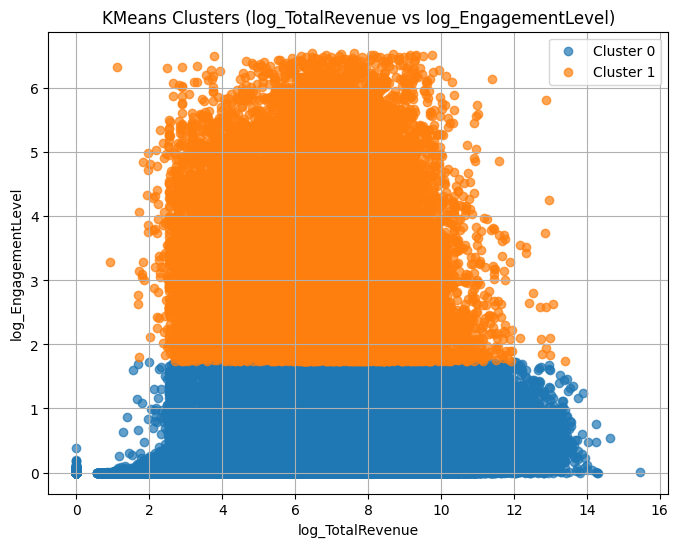

In [3]:
processor = kClusterProcessor("../Data/Processed/prsc_fe9_nov_2019.parquet")

df_features = processor.extractKMeansFeatures()
processor.logTransformFeatures()   
processor.preprocessFeatures(use_log_features=True, scaler_type='robust')
clustered_df = processor.runKMeans(n_clusters=2)
processor.visualizeClusters('TotalRevenue', 'EngagementLevel', use_log=True)
